# Laplacians and Clustering

<img src="images/clus_workflow.png" width="850">

Tutorial for hypergraph clustering utilizing random-walk based Laplacians. The hypergraph may be weighted or unweighted. 
The optional weights are associated with each **vertex-hyperedge pair**, sometimes referred to as "edge-dependent vertex weights" or "cell weights" of the incidence matrix. If unweighted, the underlying random walk is equivalent to a weighted random walk on the clique expansion (i.e. 2-section, one-mode projection) of the hypergraph. If weights are specified, the random walk isn't necessarily reversible, which implies it cannot be characterized as any random walk on an undirected graph. For more background on Laplacian-based hypergraph clustering, see

Hayashi, K., Aksoy, S. G., Park, C. H., & Park, H. 
Hypergraph random walks, laplacians, and clustering. 
In Proceedings of CIKM 2020, (2020): 495-504.

and the references contained therein. Feel free to direct inquries concerning this tutorial to Sinan Aksoy, sinan.aksoy@pnnl.gov

In [1]:
import hypernetx as hnx
import networkx as nx
from hypernetx import Entity
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, coo_matrix
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Unweighted hypergraph clustering on LesMis

A toy example of unweighted hypergraph clustering characters in the LesMis example based on scene co-occurance.

In [2]:
scenes = {
    0: ('FN', 'TH'),
    1: ('TH', 'JV'),
    2: ('BM', 'FN', 'JA'),
    3: ('JV', 'JU', 'CH', 'BM'),
    4: ('JU', 'CH', 'BR', 'CN', 'CC', 'JV', 'BM'),
    5: ('TH', 'GP'),
    6: ('GP', 'MP'),
    7: ('MA', 'GP')
}

H = hnx.Hypergraph(scenes)
hnx.spec_clus(H,3) #3 clusters

{0: ['MA', 'MP', 'GP'],
 1: ['JV', 'CH', 'CC', 'JU', 'CN', 'BR', 'BM'],
 2: ['TH', 'JA', 'FN']}

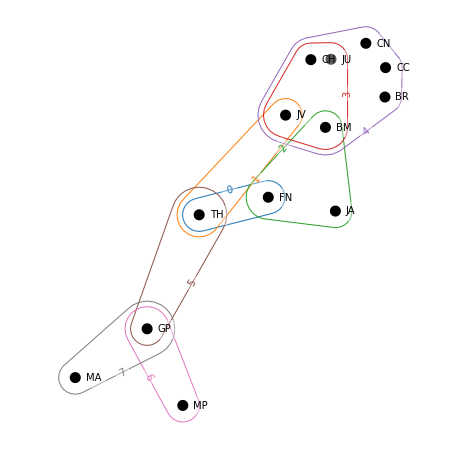

In [3]:
hnx.draw(H)

# Weighted hypergraph clustering

Hypergraph clustering on term-document data using tf-idf as cell weights. In this example, we use the 20newsgroups dataset:

https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

and consider documents falling into two subcategories. We form a static hypergraph with 787 documents as vertices, 20,868 terms as hyperedges, and tf-idf as vertex-hyperedge (i.e. cell) weights. We then form the normalized Laplacian and apply the spectral clustering algorithm as defined by "RDC-Spec" (Algorithm 1) in:

Hayashi, K., Aksoy, S. G., Park, C. H., & Park, H. 
Hypergraph random walks, laplacians, and clustering. 
In Proceedings of CIKM 2020, (2020): 495-504.

We plot the proportions of the document subcategories within each output cluster.

In [4]:
#list possible categories to choose from
all_categories = np.array((fetch_20newsgroups(subset='test').target_names))
pprint(list(enumerate(all_categories)))

[(0, 'alt.atheism'),
 (1, 'comp.graphics'),
 (2, 'comp.os.ms-windows.misc'),
 (3, 'comp.sys.ibm.pc.hardware'),
 (4, 'comp.sys.mac.hardware'),
 (5, 'comp.windows.x'),
 (6, 'misc.forsale'),
 (7, 'rec.autos'),
 (8, 'rec.motorcycles'),
 (9, 'rec.sport.baseball'),
 (10, 'rec.sport.hockey'),
 (11, 'sci.crypt'),
 (12, 'sci.electronics'),
 (13, 'sci.med'),
 (14, 'sci.space'),
 (15, 'soc.religion.christian'),
 (16, 'talk.politics.guns'),
 (17, 'talk.politics.mideast'),
 (18, 'talk.politics.misc'),
 (19, 'talk.religion.misc')]


In [5]:
#select categories of documents to be clustered
categories = all_categories[[1,15]]
twenty_train = fetch_20newsgroups(subset='test',
                                  categories=categories, shuffle=True, random_state=42)

In [6]:
#record categories of documents
doc_types=dict()
for i,x in enumerate(twenty_train.filenames):
    doc_types[i]=x.split('/')[-2]

In [7]:
#form TF-IDF term-document matrix
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(twenty_train.data)
X_tfidf

<787x20868 sparse matrix of type '<class 'numpy.float64'>'
	with 136994 stored elements in Compressed Sparse Row format>

In [8]:
#extract vertex-hyperedge incidences and weights from TFIDF matrix
mat = coo_matrix(X_tfidf)
edges = mat.col
nodes = mat.row
data = np.array([edges,nodes]).T
weights = mat.data

h = hnx.Hypergraph(hnx.StaticEntitySet(data=data,weights=weights))

In [9]:
#check the hypergraph is connected, as this is required by spectral clustering
#if not, restrict to largest connected component or modify hypergraph as necessary
h.is_connected()

True

In [10]:
# # outputs the cell weight of a selected node in a selected edge
# weight = lambda self, node, edge: self.elements[edge].cellweights[node]

#the weighted incidence matrix which contain the cell weights
I,verMap,edgeMap = h.incidence_matrix(weights=True,index=True)
I

<787x20868 sparse matrix of type '<class 'numpy.float64'>'
	with 136994 stored elements in Compressed Sparse Column format>

In [11]:
#cluster the vertices (documents)
num_clus=len(categories)
clusters=hnx.spec_clus(h,num_clus,weights=True)
print([len(v) for v in clusters.values()])

[381, 406]


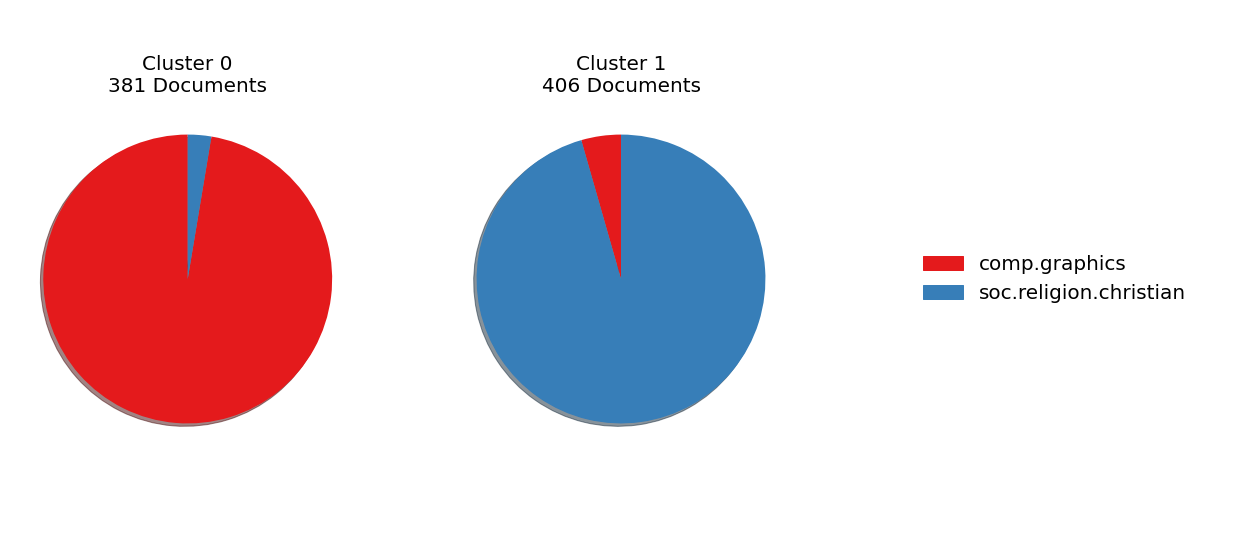

In [12]:
#visualize document category composition within each cluster
fig = plt.figure(figsize=(22, 10))
labels=sorted(list(set(doc_types.values())))
colors=['#e41a1c','#377eb8']

#pie charts
for clus in range(num_clus):
    ax=plt.subplot(131+clus)
    counts=[[doc_types[y] for y in clusters[clus]].count(z) for z in labels]
    ax.pie(counts, colors=colors, shadow=True, startangle=90)
    ax.set_title("Cluster "+repr(clus)+ "\n"+ repr(sum(counts))+ ' Documents',fontsize=20)

#legend
ax=plt.subplot(131+num_clus)
patches = [mpatches.Patch(color=color, label=label)
    for label, color in zip(labels, colors)]
ax.legend(patches, labels, loc='center',fontsize=20, frameon=False)
ax.axis('off');